In [7]:
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import os
import matplotlib.font_manager as fm

In [8]:
# font_files = ["font_type/Times New Roman.ttf", "font_type/Times New Roman Bold.ttf", 
#               "font_type/Times New Roman Italic.ttf", "font_type/Times New Roman Bold Italic.ttf"]

# for font_file in font_files:
#     if os.path.exists(font_file):
#         fm.fontManager.addfont(font_file)
        
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [9]:
model_lst_collections = ['Qwen/Qwen2.5-3B-Instruct',
                        'Qwen/Qwen2.5-7B-Instruct',
                        'Qwen/Qwen2.5-72B-Instruct-Turbo',
                        'Qwen/Qwen3-4B',
                        'Qwen/Qwen3-8B',
                        'Qwen/Qwen3-32B',
                        'google/gemma-2-2b-it', 
                        'google/gemma-2-9b-it',
                        'google/gemma-2-27b-it',
                        'gpt-4o',
                        'meta-llama/Llama-3.2-3B-Instruct',
                        'meta-llama/Llama-3.1-8B-Instruct',
                        'meta-llama/Llama-3.3-70B-Instruct-Turbo',
                        'mistralai/Ministral-8B-Instruct-2410',
                        'mistralai/Mistral-Small-24B-Instruct-2501'
                        ]

In [10]:
base_path='/mnt/ssd2/yefan/llm-verify-dynamics/verifier_data'

In [11]:
def get_model_info(model_name):
    """Extract model family and size category"""
    if 'Qwen2.5' in model_name:
        family = 'Qwen2.5'
    elif 'Qwen3' in model_name:
        family = 'Qwen3'
    elif 'Llama' in model_name:
        family = 'Llama3'
    elif 'gemma' in model_name or 'Gemma' in model_name:
        family = 'Gemma2'
    elif 'mistral' in model_name or 'Mistral' in model_name:
        family = 'Mistral'
    elif 'gpt' in model_name.lower():
        family = 'GPT-4o'
    else:
        family = 'Other'
    
    # Categorize by size
    if 'gpt-4o' in model_name.lower():
        size_category = 'large'
    else:
        size_match = re.search(r'(\d+(?:\.\d+)?)[bB]', model_name)
        if size_match:
            size_value = float(size_match.group(1))
            if size_value <= 4:
                size_category = 'small'
            elif size_value <= 32:
                size_category = 'medium'
            else:
                size_category = 'large'
        else:
            size_category = 'medium'
    
    return family, size_category

def create_aggregated_tpr_plot(all_model_results, save_path=None, label='TPR', rm_ylabel=False):
    """
    Create an aggregated TPR plot for all models with visual distinctions
    
    Parameters:
    -----------
    all_model_results: dict
        Dictionary with model names as keys and tpr_results as values
    """
    family_colors_scientific = {
        'Qwen2.5': '#EE6677',    # Light red/pink
        'Qwen3': '#4477AA',      # Blue
        'Llama3': '#228833',      # Green
        'Gemma2': '#CCBB44',      # Yellow/gold  
        'Mistral': '#66CCEE',    # Cyan
        'GPT-4o': '#AA3377',     # Purple/magenta
        'Other': '#BBBBBB'       # Gray
    }
    
    # Define visual encodings
    family_colors = {
        'Qwen2.5': '#FF6B6B',    # Warm red
        'Qwen3': '#4ECDC4',      # Teal
        'Llama3': '#95A5A6',      # Sky blue
        'Gemma2': '#4477AA',      # Sage green
        'Mistral': '#FFB347',    # Orange
        'GPT-4o': '#9B59B6',     # Purple
        'Other': '#95A5A6'       # Gray
    }
    family_colors=family_colors
    
    # Line styles for size categories
    size_linestyles = {
        'small': ':',     # Dotted line
        'medium': '--',   # Dashed line
        'large': '-'      # Solid line
    }
    
    # Markers for model families
    family_markers = {
        'Qwen2.5': 'o',
        'Qwen3': 's',
        'Llama3': '^',
        'Gemma2': 'D',
        'Mistral': 'v',
        'GPT-4o': '*',
        'Other': 'p'
    }
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    # X-axis positions for difficulty levels
    x_positions = np.arange(4)
    x_labels = ['Hardest', 'Hard', 'Easy', 'Easiest']
    
    # Track what's been added to legend
    legend_families = set()
    legend_sizes = set()
    
    # Plot each model
    for model_name, tpr_results in all_model_results.items():
        family, size_category = get_model_info(model_name)
        print(model_name, family)
        
        # Extract TPR values and confidence intervals
        tpr_values = [item[1] for item in tpr_results]
        tpr_lowers = [item[2] for item in tpr_results]
        tpr_uppers = [item[3] for item in tpr_results]
        
        # Determine if we need to add to legend
        add_to_legend = family not in legend_families
        legend_families.add(family)
        
        # Plot line with error bands
        line = ax.plot(x_positions, tpr_values,
                      color=family_colors.get(family, '#95A5A6'),
                      linestyle=size_linestyles[size_category],
                      linewidth=2,
                      marker=family_markers.get(family, 'o'),
                      markersize=8,
                      markerfacecolor='white',
                      markeredgewidth=2,
                      label=family if add_to_legend else "",
                      alpha=0.8,
                      zorder=5)
        
        # Add confidence interval as shaded area (subtle)
        ax.fill_between(x_positions, tpr_lowers, tpr_uppers,
                        color=family_colors.get(family, '#95A5A6'),
                        alpha=0.1,
                        zorder=1)
        
        # Add error bars at each point
        for i, (val, lower, upper) in enumerate(zip(tpr_values, tpr_lowers, tpr_uppers)):
            ax.errorbar(i, val, yerr=[[val-lower], [upper-val]],
                       fmt='none',
                       ecolor=family_colors.get(family, '#95A5A6'),
                       capsize=3,
                       capthick=1,
                       alpha=0.5,
                       zorder=3)
    
    # Styling
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=20)
    ax.set_xlabel('Problem Difficulty', fontsize=20)
    if not rm_ylabel:
        if label == 'TPR':
            ax.set_ylabel('True Positive Rate', fontsize=20)
        elif label == 'TNR':
            ax.set_ylabel('True Negative Rate', fontsize=20)
    #ax.set_title('Model Performance Across Difficulty Levels', fontsize=18, pad=20)
    
    # Set y-axis limits
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-0.2, 3.2)
    
    # Grid
    ax.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    ax.set_axisbelow(True)
    
    # Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Aggregated plot saved: {save_path}")
    
    plt.show()

In [12]:
def wilson_confidence_interval(successes, trials, confidence=0.95):
    """Calculate Wilson score confidence interval for proportions"""
    if trials == 0:
        return 0, 0, 0
    
    z = stats.norm.ppf(1 - (1 - confidence) / 2)  # 1.96 for 95% CI
    p_hat = successes / trials
    
    denominator = 1 + z**2 / trials
    center = (p_hat + z**2 / (2 * trials)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * trials)) / trials) / denominator
    
    lower = max(0, center - margin)
    upper = min(1, center + margin)
    
    return p_hat, lower, upper

In [13]:
def calculate_bins(model_name, 
                model_data_gen_diff, 
                percentile_ranges=[(0, 50), (50, 100)]):

    # Get all pass rates and sort them
    pass_rates = [item[-1] for item in model_data_gen_diff[model_name]]
    sorted_pass_rates = sorted(pass_rates)
    n_problems = len(sorted_pass_rates)
    
    problems_by_range = [[] for _ in percentile_ranges]
    
    items_with_rates = [(item, item[-1], idx) for idx, item in enumerate(model_data_gen_diff[model_name])]
    items_sorted = sorted(items_with_rates, key=lambda x: (x[1], x[2]))  # Sort by pass_rate, then by original index
    
    # Assign items to ranges based on their position in the sorted list
    for i, (low_p, high_p) in enumerate(percentile_ranges):
        start_idx = int(n_problems * low_p / 100)
        end_idx = int(n_problems * high_p / 100)
        
        # Ensure valid indices
        start_idx = max(0, min(start_idx, n_problems))
        end_idx = max(0, min(end_idx, n_problems))
        
        if i == len(percentile_ranges) - 1:
            end_idx = n_problems
  
        for j in range(start_idx, end_idx):
            if j < len(items_sorted):
                problems_by_range[i].append(items_sorted[j][0])  
    
    thresholds = []
    for i, problems in enumerate(problems_by_range):
        if len(problems) > 0:
            min_rate = min(item[-1] for item in problems)
            max_rate = max(item[-1] for item in problems)
            thresholds.append((min_rate, max_rate))
        else:
            thresholds.append((0, 0))  # Empty range
            
    range_info = {
        'percentile_ranges': percentile_ranges,
        'thresholds': thresholds,
        'counts': [len(problems) for problems in problems_by_range],
        'labels': [f'{low}%-{high}%' for low, high in percentile_ranges],
        'fixed_threshold': None
    }
    
    return problems_by_range, range_info


In [14]:
diff_path = '/mnt/ssd2/yefan/llm-verify-dynamics/generator_data/math/model_gen_diff_math.npy'

problem_diff = np.load(diff_path, allow_pickle=True).item()

problems_by_range, range_info = calculate_bins(
                        model_name='mean_across_models',
                        model_data_gen_diff=problem_diff,
                        percentile_ranges=[(0, 25), (25, 50), (50, 75), (75, 100)])

Qwen/Qwen2.5-3B-Instruct Qwen2.5
Qwen/Qwen2.5-7B-Instruct Qwen2.5
Qwen/Qwen2.5-72B-Instruct-Turbo Qwen2.5
Qwen/Qwen3-4B Qwen3
Qwen/Qwen3-8B Qwen3
Qwen/Qwen3-32B Qwen3
google/gemma-2-2b-it Gemma2
google/gemma-2-9b-it Gemma2
google/gemma-2-27b-it Gemma2
gpt-4o GPT-4o
meta-llama/Llama-3.2-3B-Instruct Llama3
meta-llama/Llama-3.1-8B-Instruct Llama3
meta-llama/Llama-3.3-70B-Instruct-Turbo Llama3
mistralai/Ministral-8B-Instruct-2410 Mistral
mistralai/Mistral-Small-24B-Instruct-2501 Mistral
Aggregated plot saved: figures/tpr_across_model_math.pdf


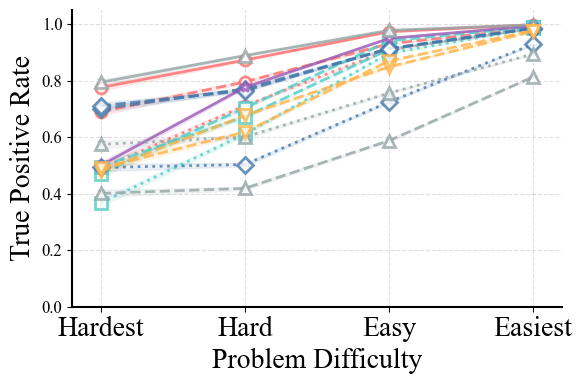

Qwen/Qwen2.5-3B-Instruct Qwen2.5
Qwen/Qwen2.5-7B-Instruct Qwen2.5
Qwen/Qwen2.5-72B-Instruct-Turbo Qwen2.5
Qwen/Qwen3-4B Qwen3
Qwen/Qwen3-8B Qwen3
Qwen/Qwen3-32B Qwen3
google/gemma-2-2b-it Gemma2
google/gemma-2-9b-it Gemma2
google/gemma-2-27b-it Gemma2
gpt-4o GPT-4o
meta-llama/Llama-3.2-3B-Instruct Llama3
meta-llama/Llama-3.1-8B-Instruct Llama3
meta-llama/Llama-3.3-70B-Instruct-Turbo Llama3
mistralai/Ministral-8B-Instruct-2410 Mistral
mistralai/Mistral-Small-24B-Instruct-2501 Mistral
Aggregated plot saved: figures/tnr_across_model_math.pdf


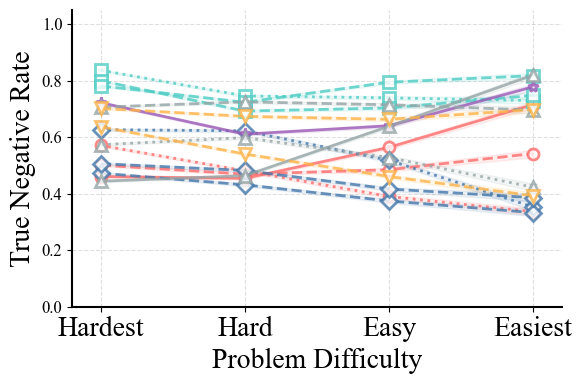

In [16]:

judge_hyper='temp0.0_topp1.0_seqs1'

all_model_results = {}
all_model_results_tnr = {}
for model in model_lst_collections:

    judge_acc_path = os.path.join(base_path,
                                model, 
                                f'single_verification/{judge_hyper}/vanilla', 
                                f'math_balanced_subsample_4_metrics.npy')
    
    #judge_acc_dictionary (dataset_source, dataset_idx): (acc, true_acc, false_acc)
    judge_acc_dictionary = np.load(judge_acc_path, allow_pickle=True).item()

    tpr_results = []
    tnr_results = []
    for range_idx, range_problems in enumerate(problems_by_range):
        #true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0
        true_correct_neg_one_half, true_false_neg_one_half = 0, 0
        total_true, total_false = 0, 0
        for key in range_problems:
            lookup_key = (key[0], key[1])
            if lookup_key in judge_acc_dictionary:
                total_true += judge_acc_dictionary[lookup_key]['total_true']
                total_false += judge_acc_dictionary[lookup_key]['total_false']
                true_correct_neg_one_half += judge_acc_dictionary[lookup_key]['true_correct_neg_one_half']
                true_false_neg_one_half += judge_acc_dictionary[lookup_key]['true_false_neg_one_half']
                
        p_hat, lower, upper = wilson_confidence_interval(true_correct_neg_one_half, total_true, confidence=0.95)
        p_hat_true_neg, lower_true_neg, upper_true_neg = wilson_confidence_interval(true_false_neg_one_half, total_false, confidence=0.95)
        
        quantile_name = ['Hardest', 'Hard', 'Easy', 'Easiest'][range_idx]
        tpr_results.append((quantile_name, p_hat, lower, upper))
        tnr_results.append((quantile_name, p_hat_true_neg, lower_true_neg, upper_true_neg))
    
    all_model_results[model] = tpr_results
    all_model_results_tnr[model] = tnr_results
    
    
create_aggregated_tpr_plot(all_model_results, 
                          save_path='figures/tpr_across_model_math.pdf', label='TPR')
create_aggregated_tpr_plot(all_model_results_tnr, 
                          save_path='figures/tnr_across_model_math.pdf', label='TNR')